In [4]:
!pip install alpha_vantage


In [5]:
!pip install pandas

### Obten Tu Clave de API 
- https://www.alphavantage.co/

In [0]:
from alpha_vantage.timeseries import TimeSeries
import json


def save_dataset(symbol):
    api_key ='9XZTXGV663EISDLG'
    
    ts = TimeSeries(key=api_key, output_format='pandas')
    data, meta_data = ts.get_daily(symbol, outputsize='full')
    data.to_csv('./{}_daily.csv'.format(symbol))

In [0]:
simbolo = 'AAPL'
save_dataset(simbolo)

### Listado de Acciones

ftp://ftp.nasdaqtrader.com/SymbolDirectory

#### Símbolos 
- AMZN, FB, GOOGL, MSFT, NFLX, AAPL

### Procesa los DATOS

In [0]:
nombre_archivo = '{}_daily.csv'.format(simbolo)

In [0]:
import pandas as pd
from sklearn import preprocessing
import numpy as np

history_points = 50

def csv_to_dataset(csv_path):
    datos = pd.read_csv(csv_path)

    print('Datos: ', datos.head(),'\n')

    # Elimina el primer día
    datos  = datos.drop(0, axis=0)

    # Ordena de más viejo a  más reciente
    datos = datos.sort_values('date')
    print('Datos por Fecha: ', datos.head(),'\n')

    # Elimina la columna 'date'  
    datos = datos.drop('date', axis=1)

    print("Tipo de de los Datos:", type(datos),'\n')
    print("Datos: ", datos[:10],'\n')


    normalizador = preprocessing.MinMaxScaler()
    datos_norm = normalizador.fit_transform(datos)

    print("Datos normalizados", datos_norm[:10],'\n')
    # Usamos los últimos 50 ejemplos para predecir el siguiente valor (open)
    # X
    ohlcv_histories_normalised =      np.array([datos_norm[i  : i + history_points].copy() for i in range(len(datos_norm) - history_points)])
    
    
    #y
    next_day_open_values_normalised = np.array([datos_norm[:,0][i + history_points].copy() for i in range(len(datos_norm) - history_points)])
    next_day_open_values = np.array([datos.iloc[:,0][i + history_points].copy() for i in range(len(datos) - history_points)])
    next_day_open_values = np.expand_dims(next_day_open_values_normalised, -1)
    print('next_day_open_values shape: ',next_day_open_values.shape)
    print(next_day_open_values[:10], sep = '\n')

    
    y_scaler = preprocessing.MinMaxScaler()
    y_scaler.fit( next_day_open_values  )

    # Indicadores tecnicos
    technical_indicators = []
    for his in ohlcv_histories_normalised:
        # Promedio del Precio de cierre 
        sma = np.mean(his[:,3])
        technical_indicators.append(np.array([sma]))

    technical_indicators = np.array(technical_indicators)
		
    tech_ind_scaler = preprocessing.MinMaxScaler()
    technical_indicators_normalised = tech_ind_scaler.fit_transform(technical_indicators)



    # Verifica que el número de xs sea igual al número de ys
    assert ohlcv_histories_normalised.shape[0] == next_day_open_values_normalised.shape[0] == technical_indicators_normalised.shape[0]

    return ohlcv_histories_normalised, technical_indicators_normalised, next_day_open_values_normalised, next_day_open_values, y_scaler  

In [10]:
ohlcv_histories, technical_indicators, next_day_open_values, unscaled_y, y_scaler = csv_to_dataset('{}_daily.csv'.format(simbolo))

test_split = 0.9
n = int(ohlcv_histories.shape[0] * test_split)

ohlcv_train = ohlcv_histories[:n]
tech_ind_train = technical_indicators[:n]
y_train = next_day_open_values[:n]

ohlcv_test = ohlcv_histories[n:]
tech_ind_test = technical_indicators[n:]
y_test = next_day_open_values[n:]

unscaled_y_test = unscaled_y[n:]

Datos:           date  1. open   2. high  3. low  4. close   5. volume
0  2020-03-27   252.75  255.8700  247.05    247.74  51054153.0
1  2020-03-26   246.52  258.6800  246.36    258.44  63140169.0
2  2020-03-25   250.75  258.2500  244.30    245.52  75900510.0
3  2020-03-24   236.36  247.6900  234.30    246.88  71882773.0
4  2020-03-23   228.08  228.4997  212.61    224.37  84188208.0 

Datos por Fecha:              date  1. open  2. high  3. low  4. close  5. volume
5032  2000-03-27   137.63   144.75  136.88    139.56  2492700.0
5031  2000-03-28   137.25   142.00  137.13    139.13  1812200.0
5030  2000-03-29   139.38   139.44  133.83    135.94  2141400.0
5029  2000-03-30   133.56   137.69  125.44    125.75  3700000.0
5028  2000-03-31   127.44   137.25  126.00    135.81  3612800.0 

Tipo de de los Datos: <class 'pandas.core.frame.DataFrame'> 

Datos:        1. open  2. high  3. low  4. close  5. volume
5032   137.63   144.75  136.88    139.56  2492700.0
5031   137.25   142.00  137.13    

### Modelo

In [11]:
### Usa tensorflow 1.x
%tensorflow_version 1.x


TensorFlow 1.x selected.


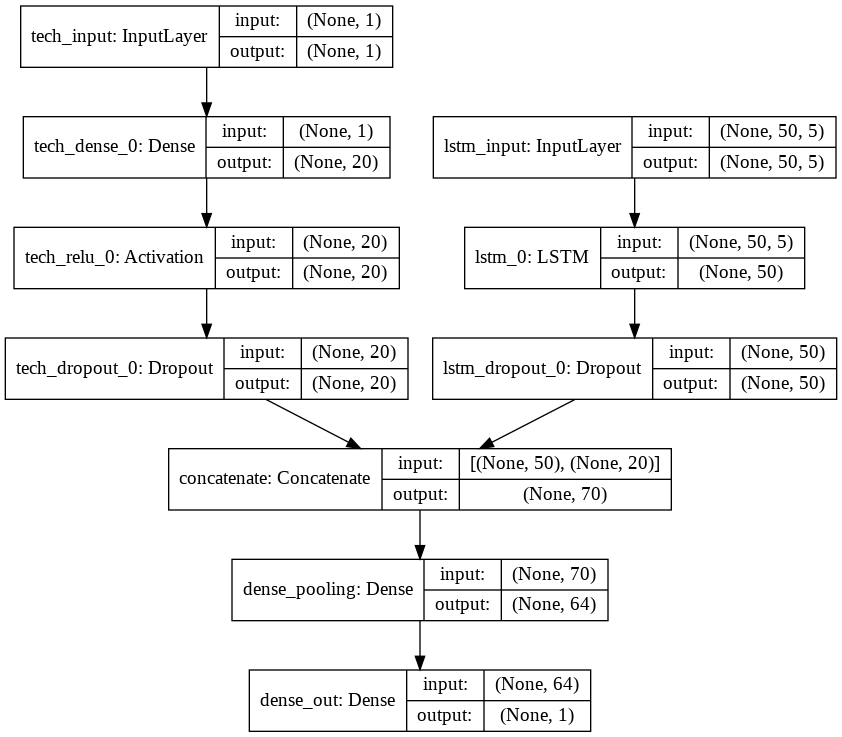

In [13]:
import keras
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
from keras import optimizers
import numpy as np



# define two sets of inputs
lstm_input = Input(shape=(history_points, 5), name='lstm_input')
dense_input = Input(shape=(technical_indicators.shape[1],), name='tech_input')
 
# the first branch operates on the first input
x = LSTM(50, name='lstm_0')(lstm_input)
x = Dropout(0.2, name='lstm_dropout_0')(x)
lstm_branch = Model(inputs=lstm_input, outputs=x)
 
# the second branch opreates on the second input
y = Dense(20, name='tech_dense_0')(dense_input)
y = Activation("relu", name='tech_relu_0')(y)
y = Dropout(0.2, name='tech_dropout_0')(y)
technical_indicators_branch = Model(inputs=dense_input, outputs=y)
 
# combine the output of the two branches
combined = concatenate([lstm_branch.output, technical_indicators_branch.output], name='concatenate')
 
z = Dense(64, activation="sigmoid", name='dense_pooling')(combined)
z = Dense(1, activation="linear", name='dense_out')(z)
 
# our model will accept the inputs of the two branches and then output a single value
model = Model(inputs=[lstm_branch.input, technical_indicators_branch.input], outputs=z)

adam = optimizers.Adam(lr=0.0005)

model.compile(optimizer=adam,
              loss='mse')

from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

### Entrenamiento

In [14]:
model.fit(x=[ohlcv_train, tech_ind_train], y=y_train, batch_size=32, epochs=50, shuffle=True, validation_split=0.1)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 4034 samples, validate on 449 samples
Epoch 1/50





4034/4034 [==============================] - 6s 1ms/step - loss: 0.0108 - val_loss: 5.0975e-05
Epoch 2/50
4034/4034 [==============================] - 5s 1ms/step - loss: 0.0016 - val_loss: 4.4535e-05
Epoch 3/50
4034/4034 [==============================] - 4s 1ms/step - loss: 0.0013 - val_loss: 4.2669e-05
Epoch 4/50
4034/4034 [==============================] - 4s 1ms/step - loss: 0.0012 - val_loss: 2.4748e-05
Epoch 5/50
4034/4034 [==============================] - 4s 1ms/step - loss: 0.0011 - val_loss: 2.4249e-05
Epoch 6/50
4034/4034 [==============================] - 5s 1ms/step - loss: 9.7439e-04 - val_loss: 1.2647e-04
Epoch 7/50
4034/4034 [==============================] - 5s 1ms/step - loss: 9.4096e-04 - val_loss: 3.5909e-05
Epoch 8/50
4034/4034 [==============================] - 4s 1ms/step - loss: 9.0074e-04 - val_loss: 3.

### Evaluacion

In [15]:
# Las predicciones estásn normalizadas
y_test_predicted = model.predict([ohlcv_test, tech_ind_test])

y_test_predicted = y_scaler.inverse_transform(y_test_predicted)

real_mse = np.mean(np.square(unscaled_y_test - y_test_predicted))
scaled_mse = real_mse / (np.max(unscaled_y_test) - np.min(unscaled_y_test)) * 100
print(scaled_mse)

0.021114972888503083


### Visualización

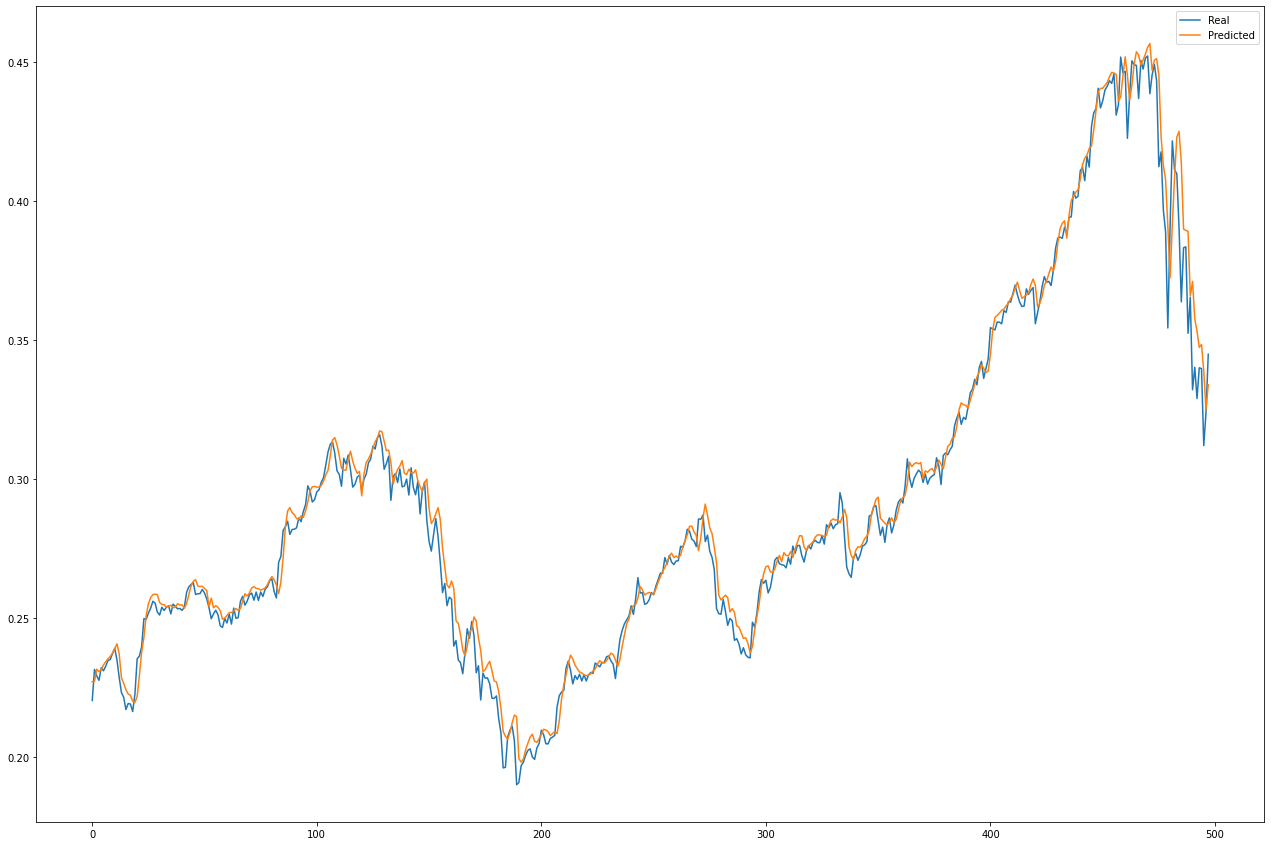

In [16]:
import matplotlib.pyplot as plt
plt.gcf().set_size_inches(22, 15, forward=True)

start = 0
end = -1

real = plt.plot(unscaled_y_test[start:end], label='real')
pred = plt.plot(y_test_predicted[start:end], label='predicted')

plt.legend(['Real', 'Predicted'])

plt.show()


In [17]:
buys = []
sells = []
thresh = 0.01#0.2

x = 0
for ohlcv, ind in zip(ohlcv_test, tech_ind_test):
    normalised_price_today = ohlcv[-1][0]
    normalised_price_today = np.array([[normalised_price_today]])
    price_today = y_scaler.inverse_transform(normalised_price_today)
    predicted = np.squeeze(y_scaler.inverse_transform( model.predict([[ohlcv], [ind]])))
    delta = predicted - price_today
    # print(delta)
    if delta > thresh:
        buys.append((x, price_today[0][0]))
    elif delta < -thresh:
        sells.append((x, price_today[0][0]))
    x += 1
print(len(buys))
print(len(sells))

19
1


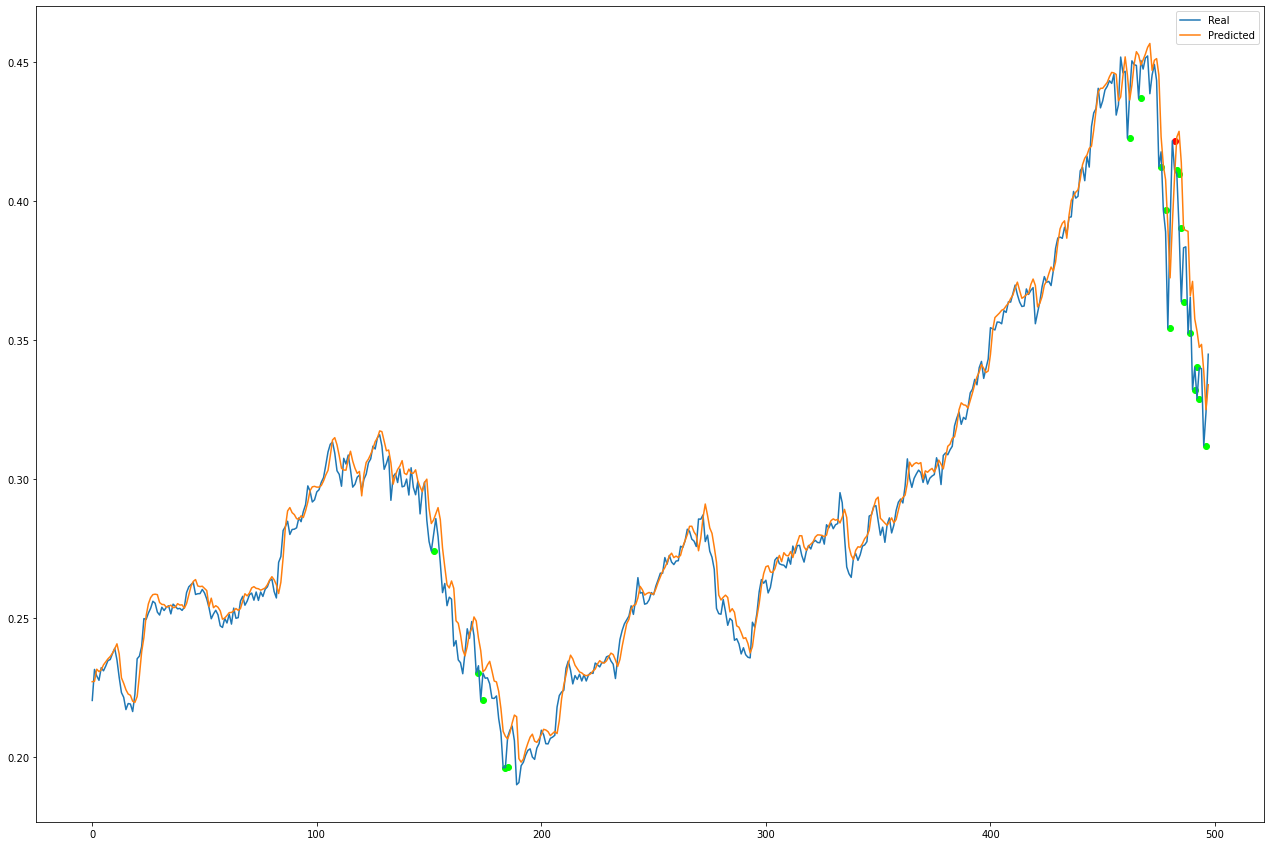

In [22]:
import matplotlib.pyplot as plt

plt.gcf().set_size_inches(22, 15, forward=True)

start = 0
end = -1

real = plt.plot(unscaled_y_test[start:end], label='real')
pred = plt.plot(y_test_predicted[start:end], label='predicted')

plt.scatter(list(list(zip(*buys))[0]), list(list(zip(*buys))[1]), c='#00ff00')  # verde
plt.scatter(list(list(zip(*sells))[0]), list(list(zip(*sells))[1]), c='#ff0000') # rojo

# real = plt.plot(unscaled_y[start:end], label='real')
# pred = plt.plot(y_predicted[start:end], label='predicted')

plt.legend(['Real', 'Predicted'])


plt.savefig('predicciones.png')

plt.show()

### GANANCIAS 


In [0]:
def compute_earnings(buys, sells):
    purchase_amt = 10
    stock = 0
    balance = 0
    while len(buys) > 0 and len(sells) > 0:
        if buys[0][0] < sells[0][0]:
            # time to buy $10 worth of stock
            balance -= purchase_amt
            stock += purchase_amt / buys[0][1]
            buys.pop(0)
        else:
            # time to sell all of our stock
            balance += stock * sells[0][1]
            stock = 0
            sells.pop(0)
    print(balance)

In [0]:
compute_earnings(buys, sells)

1.899946780202237


# REFERENCIA 

- [Código Original](https://towardsdatascience.com/getting-rich-quick-with-machine-learning-and-stock-market-predictions-696802da94fe)